In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from OutilsP4 import *
import seaborn as sns
import xgboost as xgb
import shap

#Sci-Kit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder

from category_encoders import TargetEncoder

from sklearn.pipeline import make_pipeline

from sklearn.compose import make_column_transformer
from sklearn.compose import TransformedTargetRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold

from sklearn.decomposition import PCA
from mlxtend.plotting import plot_pca_correlation_graph

In [2]:
# On ingnorera les warning concernant les prochaines versions
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# <font color='red'> INITIALISATION </font> 
### <font color='green'> Import des datas </font> 

Il y a 5638 valeurs manquantes sur 76500 valeurs totales.
Le taux de remplissage est de : 92.63 %
Dimension du dataframe : (1500, 51)


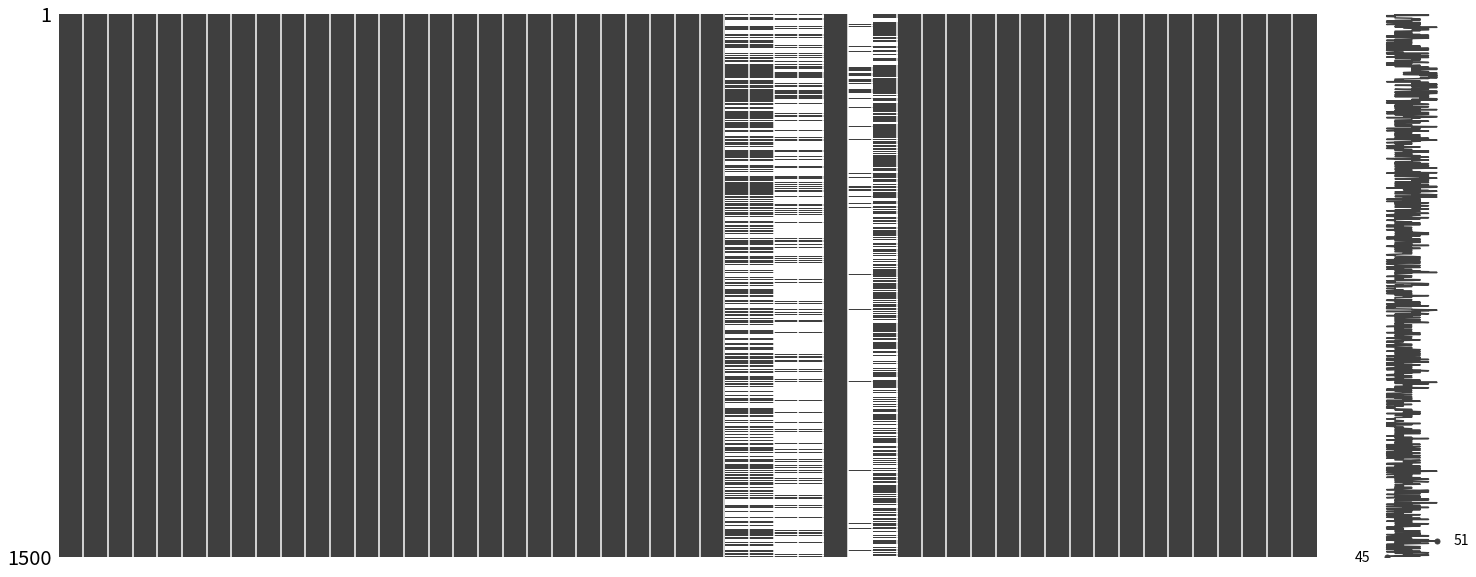

In [3]:
data = pd.read_csv("modelData.csv", sep=';')
missingValuesInfos(data)

### <font color='green'> Stockage des scores
</font> 

In [4]:
bestModelsDF = pd.DataFrame(index = ["Linear Regression","Ridge Regression","Lasso","Random Forest Regressor","Random Forest Regressor & Polynomial Features","Random Forest Regressor & Logarithmic transformer","Gradient Boosting Regressor"],
                            columns=['params','mean_train_neg_root_mean_squared_error','mean_train_r2','mean_test_neg_root_mean_squared_error','mean_test_r2','mean_fit_time'])
TestR2 = []
TestRMSE = []

In [5]:
data.columns

Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Address', 'ZipCode', 'TaxParcelIdentificationNumber',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'DistanceFromCenter', 'YearBuilt', 'BuildingAge', 'BuildingPeriod',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAPerFloor', 'PropertyGFAParking', 'PropertyGFApctParking',
       'PropertyGFABuilding(s)', 'PropertyGFApctBuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'LargestPropertyUseTypeGFApct',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'NumberOfUseTypes', 'YearsENERGYSTARCertified', 'ENERGYSTARScore',
       'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
       '

### <font color='green'> Séléction des datas </font> 

In [6]:
X_data = data.loc[:,["BuildingAge",'LargestPropertyUseType','Neighborhood','PropertyGFAPerFloor',"LargestPropertyUseTypeGFApct",
                     'PropertyGFApctBuilding(s)',"NumberofBuildings","NumberofFloors","BuildingType","NumberOfUseTypes","SteamProdPct","ElectricityProdPct"]].copy()
Y_data = data.loc[:,'SiteEnergyUse(kBtu)'].copy()

In [7]:
cv = ShuffleSplit(5, test_size = 0.2, random_state = 5)

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, train_size = 0.8, random_state = 0)
X_test.reset_index(inplace = True, drop = True)
Y_test.reset_index(inplace = True, drop = True)
X_train.reset_index(inplace = True, drop = True)
Y_train.reset_index(inplace = True, drop = True)

print("X_data.shape",X_data.shape)
print("Y_data.shape",Y_data.shape)
print("\nX_train.shape",X_train.shape)
print("Y_train.shape",Y_train.shape)
print("\nX_test.shape",X_test.shape)
print("Y_test.shape",Y_test.shape)

X_data.shape (1500, 12)
Y_data.shape (1500,)

X_train.shape (1200, 12)
Y_train.shape (1200,)

X_test.shape (300, 12)
Y_test.shape (300,)


In [8]:
categoricalFeatures = ['BuildingType','LargestPropertyUseType','Neighborhood']
numericalFeatures = ["BuildingAge",'PropertyGFAPerFloor',"LargestPropertyUseTypeGFApct",
                       'PropertyGFApctBuilding(s)',"NumberofBuildings","NumberofFloors","NumberOfUseTypes","SteamProdPct","ElectricityProdPct"]

### <font color='green'> Montage des transformeurs </font> 

In [9]:
choixEncoder = False
while (choixEncoder != "0" and choixEncoder != "1") :
    print("Choisir  : TargetEcnoder = 1 / OneHotEncoder = 0")
    choixEncoder = input("Transformer ? :")

if choixEncoder == "0" :
    transformer = make_column_transformer((OneHotEncoder(handle_unknown = 'error', sparse = False),categoricalFeatures),(StandardScaler(),numericalFeatures))
    transformerPoly = make_column_transformer((OneHotEncoder(handle_unknown = 'error', sparse = False),categoricalFeatures),(StandardScaler(),numericalFeatures), (PolynomialFeatures(3), numericalFeatures))
    choixEncoder = "OneHotEncoder"
elif choixEncoder == "1" :
    transformer = make_column_transformer((TargetEncoder(),categoricalFeatures),(StandardScaler(),numericalFeatures))
    transformerPoly = make_column_transformer((TargetEncoder(),categoricalFeatures),(StandardScaler(),numericalFeatures), (PolynomialFeatures(3), numericalFeatures))
    choixEncoder = "TargetEncoder"
    

Choisir  : TargetEcnoder = 1 / OneHotEncoder = 0


Transformer ? : 1


### <font color='green'> Corrélation des variables </font> 

<AxesSubplot:>

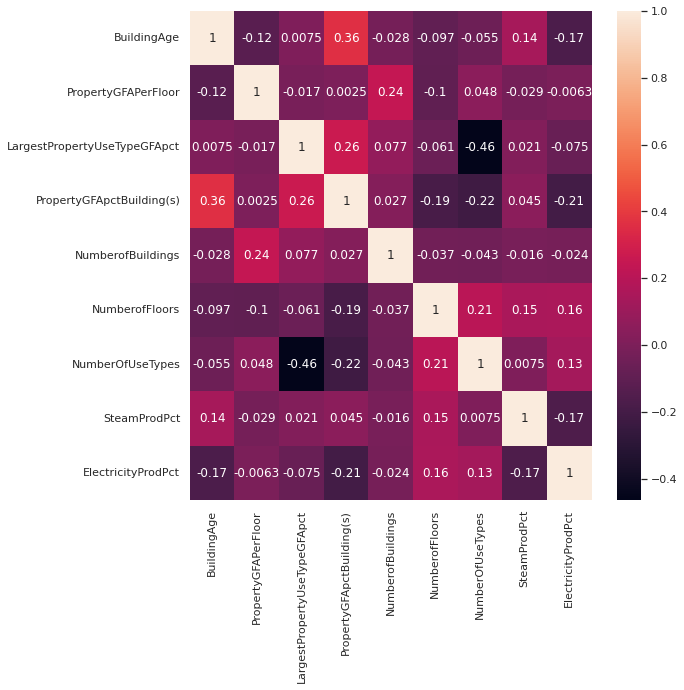

In [10]:
sns.set(rc={'figure.figsize':(9,9)})
sns.heatmap(X_data.corr(), annot = True)

# <font color='red'> 1r Test modèle - LinearRegression </font>

### <font color='green'>Pipeline </font>

In [11]:
model = make_pipeline(transformer,LinearRegression())
model.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['BuildingType',
                                                   'LargestPropertyUseType',
                                                   'Neighborhood']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['BuildingAge',
                                                   'PropertyGFAPerFloor',
                                                   'LargestPropertyUseTypeGFApct',
                                                   'PropertyGFApctBuilding(s)',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                   

### <font color='green'> GridSearchCV </font>

In [12]:
params = {'linearregression__fit_intercept' : [True,False]}

In [13]:
grid = GridSearchCV(model, param_grid = params, cv = cv, scoring = ['neg_root_mean_squared_error','r2'], refit='neg_root_mean_squared_error',return_train_score=True)
grid.fit(X_train, Y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=5, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['BuildingType',
                                                                          'LargestPropertyUseType',
                                                                          'Neighborhood']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['BuildingAge',
                                                                          'PropertyGFAPerFloor',
                   

In [14]:
print("Meilleurs paramètres :")
grid.best_params_

Meilleurs paramètres :


{'linearregression__fit_intercept': False}

### <font color='green'> Scores </font>

In [15]:
#Récupération du meilleur estimateur
model = grid.best_estimator_.fit(X_train, Y_train)
TestRMSE.append(mean_squared_error(Y_test, model.predict(X_test), squared = False))
TestR2.append(r2_score(Y_test, model.predict(X_test)))
bestModelsDF = saveBestModel(name = "Linear Regression", gridResults = pd.DataFrame(grid.cv_results_), resultsDF = bestModelsDF)

# <font color='red'> 2e Test modèle - Ridge </font>

### <font color='green'>Pipeline </font>

In [16]:
model = make_pipeline(transformer,Ridge())
model.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['BuildingType',
                                                   'LargestPropertyUseType',
                                                   'Neighborhood']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['BuildingAge',
                                                   'PropertyGFAPerFloor',
                                                   'LargestPropertyUseTypeGFApct',
                                                   'PropertyGFApctBuilding(s)',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                   

### <font color='green'> GridSearchCV </font>

In [17]:
params = {'ridge__fit_intercept' : [True,False],
          'ridge__alpha' : [0.1*i for i in range(11)]}

In [18]:
grid = GridSearchCV(model, param_grid = params, cv = cv, scoring = ['neg_root_mean_squared_error','r2'], refit='neg_root_mean_squared_error',return_train_score=True)
grid.fit(X_train, Y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=5, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['BuildingType',
                                                                          'LargestPropertyUseType',
                                                                          'Neighborhood']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['BuildingAge',
                                                                          'PropertyGFAPerFloor',
                   

In [19]:
print("Meilleurs paramètres :")
grid.best_params_

Meilleurs paramètres :


{'ridge__alpha': 1.0, 'ridge__fit_intercept': False}

### <font color='green'> Scores </font>

In [20]:
#Récupération du meilleur estimateur
model = grid.best_estimator_.fit(X_train, Y_train)
TestRMSE.append(mean_squared_error(Y_test, model.predict(X_test), squared = False))
TestR2.append(r2_score(Y_test, model.predict(X_test)))
bestModelsDF = saveBestModel(name = "Ridge Regression", gridResults = pd.DataFrame(grid.cv_results_), resultsDF = bestModelsDF)

# <font color='red'> 3e Test modèle - Lasso </font>

### <font color='green'>Pipeline </font>

In [21]:
model = make_pipeline(transformer,Lasso(max_iter=3000))
model.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['BuildingType',
                                                   'LargestPropertyUseType',
                                                   'Neighborhood']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['BuildingAge',
                                                   'PropertyGFAPerFloor',
                                                   'LargestPropertyUseTypeGFApct',
                                                   'PropertyGFApctBuilding(s)',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                   

### <font color='green'> GridSearchCV </font>

In [22]:
params = {'lasso__fit_intercept' : [True,False],
          'lasso__alpha' : [0.1*i for i in range(1,11)]}

In [23]:
grid = GridSearchCV(model, param_grid = params, cv = cv, scoring = ['neg_root_mean_squared_error','r2'], refit='r2',return_train_score=True)
grid.fit(X_train, Y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=5, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['BuildingType',
                                                                          'LargestPropertyUseType',
                                                                          'Neighborhood']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['BuildingAge',
                                                                          'PropertyGFAPerFloor',
                   

In [24]:
print("Meilleurs paramètres :")
grid.best_params_

Meilleurs paramètres :


{'lasso__alpha': 1.0, 'lasso__fit_intercept': False}

### <font color='green'> Scores </font>

In [25]:
#Récupération du meilleur estimateur
model = grid.best_estimator_.fit(X_train, Y_train)
TestRMSE.append(mean_squared_error(Y_test, model.predict(X_test), squared = False))
TestR2.append(r2_score(Y_test, model.predict(X_test)))
bestModelsDF = saveBestModel(name = "Lasso", gridResults = pd.DataFrame(grid.cv_results_), resultsDF = bestModelsDF)

# <font color='red'> 4e Test modèle - RandomForestRegressor </font>

### <font color='green'>Pipeline </font>

In [26]:
model = make_pipeline(transformer, RandomForestRegressor(random_state = 0))

### <font color='green'> GridSearchCV </font>

In [27]:
params = {'randomforestregressor__n_estimators' : [15,20,25,35,40,45,50,100],
          'randomforestregressor__max_features' : ['sqrt','log2'],
          'randomforestregressor__max_depth' : [13,15,17,18,19,20,22,25],
          'randomforestregressor__bootstrap' : [True,False],
          'randomforestregressor__min_samples_split' : [2,3,4],
          'randomforestregressor__min_samples_leaf' : [1,2,3]}

In [28]:
grid = GridSearchCV(model, param_grid = params, cv = cv, scoring = ['neg_root_mean_squared_error','r2'], refit='neg_root_mean_squared_error',return_train_score=True)
grid.fit(X_train, Y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=5, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['BuildingType',
                                                                          'LargestPropertyUseType',
                                                                          'Neighborhood']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['BuildingAge',
                                                                          'PropertyGFAPerFloor',
                   

In [29]:
print("Meilleurs paramètres :")
grid.best_params_

Meilleurs paramètres :


{'randomforestregressor__n_estimators': 35}

In [30]:
#Récupération du meilleur estimateur
model = grid.best_estimator_.fit(X_train, Y_train)
TestRMSE.append(mean_squared_error(Y_test, model.predict(X_test), squared = False))
TestR2.append(r2_score(Y_test, model.predict(X_test)))
bestModelsDF = saveBestModel(name = "Random Forest Regressor", gridResults = pd.DataFrame(grid.cv_results_), resultsDF = bestModelsDF)

### <font color='green'> Importance des variables </font>

In [31]:
X_temp = model['columntransformer'].transform(X_train)
shap_values = shap.TreeExplainer(model['randomforestregressor']).shap_values(X_temp)

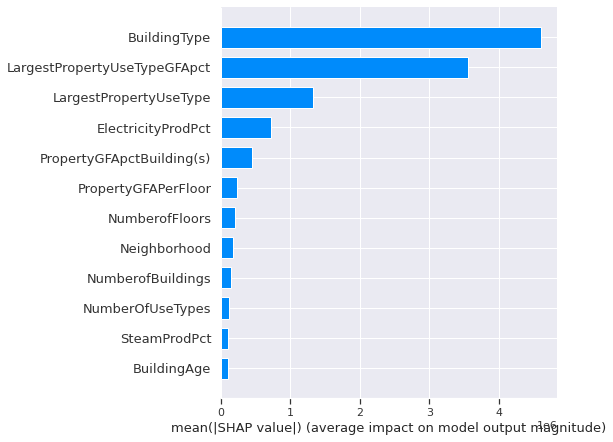

In [32]:
shap.summary_plot(shap_values, X_temp, feature_names = getColumnNames(model, choixEncoder, X_train, poly = False), plot_type="bar")

# <font color='red'> 4eBis Test modèle - RandomForest + Polynomial Features </font>

### <font color='green'>Pipeline </font>

In [33]:
model = make_pipeline(transformer,PolynomialFeatures(3), RandomForestRegressor(random_state = 0))
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['BuildingType',
                                                   'LargestPropertyUseType',
                                                   'Neighborhood']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['BuildingAge',
                                                   'PropertyGFAPerFloor',
                                                   'LargestPropertyUseTypeGFApct',
                                                   'PropertyGFApctBuilding(s)',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                   

### <font color='green'> GridSearchCV </font>

In [34]:
params = {'randomforestregressor__n_estimators' : [25,50,100],
          'randomforestregressor__max_features' : ['sqrt','log2'],
          'randomforestregressor__max_depth' : [2,3,4,5,6,7,8,9],
          'randomforestregressor__bootstrap' : [True,False]}

In [35]:
grid = GridSearchCV(model, param_grid = params, cv = cv, scoring = ['neg_root_mean_squared_error','r2'], refit='neg_root_mean_squared_error',return_train_score=True)
grid.fit(X_train, Y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=5, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['BuildingType',
                                                                          'LargestPropertyUseType',
                                                                          'Neighborhood']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['BuildingAge',
                                                                          'PropertyGFAPerFloor',
                   

In [36]:
print("Meilleurs paramètres :")
grid.best_params_

Meilleurs paramètres :


{'randomforestregressor__n_estimators': 100}

### <font color='green'> Importance des variables </font>

In [37]:
model = grid.best_estimator_.fit(X_train, Y_train)
X_temp = model['columntransformer'].transform(X_train)
X_temp = model['polynomialfeatures'].fit_transform(X_temp)
shap_values = shap.TreeExplainer(model['randomforestregressor']).shap_values(X_temp)

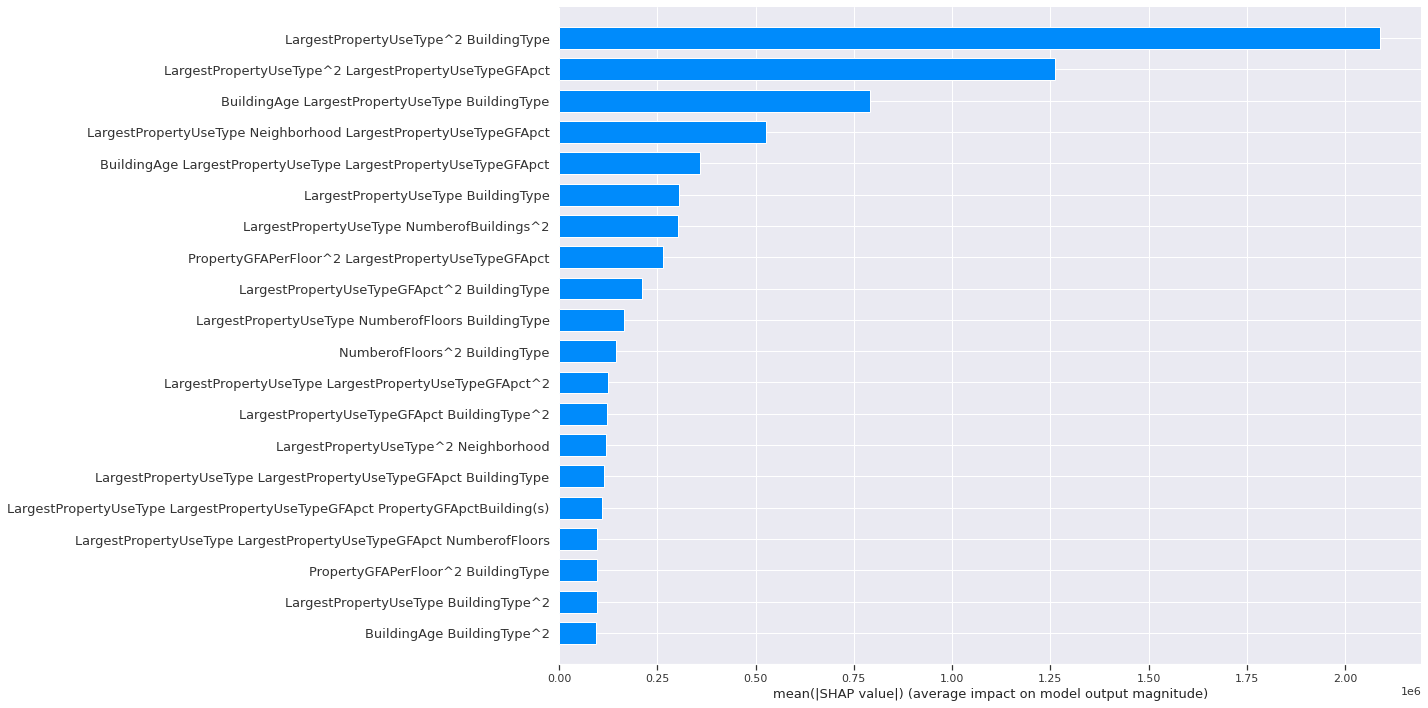

In [38]:
shap.summary_plot(shap_values, X_temp, plot_type="bar", feature_names = getColumnNames(model, choixEncoder, X_train, poly = True), plot_size = (20,10))

### <font color='green'> Scores </font>

In [39]:
#Récupération du meilleur estimateur
TestRMSE.append(mean_squared_error(Y_test, model.predict(X_test), squared = False))
TestR2.append(r2_score(Y_test, model.predict(X_test)))
bestModelsDF = saveBestModel(name = "Random Forest Regressor & Polynomial Features", gridResults = pd.DataFrame(grid.cv_results_), resultsDF = bestModelsDF)

# <font color='red'> 4eTer Test modèle - RandomForest + TransformedTargetRegressor (log) </font>

### <font color='green'>Pipeline </font>

In [40]:
model = make_pipeline(transformer, TransformedTargetRegressor(RandomForestRegressor(random_state = 0), func = log1, inverse_func = exp1, check_inverse = True))

### <font color='green'> GridSearchCV </font>

In [41]:
params = {'transformedtargetregressor__regressor__n_estimators' : [25,50,100],
          'transformedtargetregressor__regressor__max_features' : ['sqrt','log2'],
          'transformedtargetregressor__regressor__max_depth' : [2,3,4,5,6,7,8,9],
          'transformedtargetregressor__regressor__bootstrap' : [True,False]}

In [42]:
grid = GridSearchCV(model, param_grid = params, cv = cv, scoring = ['neg_root_mean_squared_error','r2'], refit='neg_root_mean_squared_error',return_train_score=True)
grid.fit(X_train, Y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=5, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['BuildingType',
                                                                          'LargestPropertyUseType',
                                                                          'Neighborhood']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['BuildingAge',
                                                                          'PropertyGFAPerFloor',
                   

In [43]:
print("Meilleurs paramètres :")
grid.best_params_

Meilleurs paramètres :


{'transformedtargetregressor__regressor__n_estimators': 25}

### <font color='green'> Scores </font>

In [44]:
#Récupération du meilleur estimateur
model = grid.best_estimator_.fit(X_train, Y_train)
TestRMSE.append(mean_squared_error(Y_test, model.predict(X_test), squared = False))
TestR2.append(r2_score(Y_test, model.predict(X_test)))
bestModelsDF = saveBestModel(name = "Random Forest Regressor & Logarithmic transformer", gridResults = pd.DataFrame(grid.cv_results_), resultsDF = bestModelsDF)

# <font color='red'> 5e Test modèle - GradientBoostingRegressor </font>

### <font color='green'>Pipeline </font>

In [45]:
model = make_pipeline(transformer, GradientBoostingRegressor(random_state = 0))
model.fit(X_train, Y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('targetencoder',
                                                  TargetEncoder(),
                                                  ['BuildingType',
                                                   'LargestPropertyUseType',
                                                   'Neighborhood']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['BuildingAge',
                                                   'PropertyGFAPerFloor',
                                                   'LargestPropertyUseTypeGFApct',
                                                   'PropertyGFApctBuilding(s)',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                   

### <font color='green'> GridSearchCV </font>

In [46]:
params = {'gradientboostingregressor__loss' : ['squared_error', 'absolute_error', 'huber', 'quantile'],
          'gradientboostingregressor__n_estimators' : [100,150,200,250],
          'gradientboostingregressor__learning_rate' : [0.1,0.15,0.2,0.25],
          'gradientboostingregressor__min_samples_split' : [2,3,4],
          'gradientboostingregressor__min_samples_leaf' : [1,2,3]}

In [47]:
grid = GridSearchCV(model, param_grid = params, cv = cv, scoring = ['neg_root_mean_squared_error','r2'], refit='neg_root_mean_squared_error',return_train_score=True)
grid.fit(X_train, Y_train)

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=5, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['BuildingType',
                                                                          'LargestPropertyUseType',
                                                                          'Neighborhood']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['BuildingAge',
                                                                          'PropertyGFAPerFloor',
                   

In [48]:
print("Meilleurs paramètres :")
grid.best_params_

Meilleurs paramètres :


{'gradientboostingregressor__n_estimators': 200}

### <font color='green'> Scores </font>

In [49]:
#Récupération du meilleur estimateur
model = grid.best_estimator_.fit(X_train, Y_train)
TestRMSE.append(mean_squared_error(Y_test, model.predict(X_test), squared = False))
TestR2.append(r2_score(Y_test, model.predict(X_test)))
bestModelsDF = saveBestModel(name = "Gradient Boosting Regressor", gridResults = pd.DataFrame(grid.cv_results_), resultsDF = bestModelsDF)

In [50]:
X_temp = model['columntransformer'].transform(X_train)
shap_values = shap.TreeExplainer(model['gradientboostingregressor']).shap_values(X_temp)

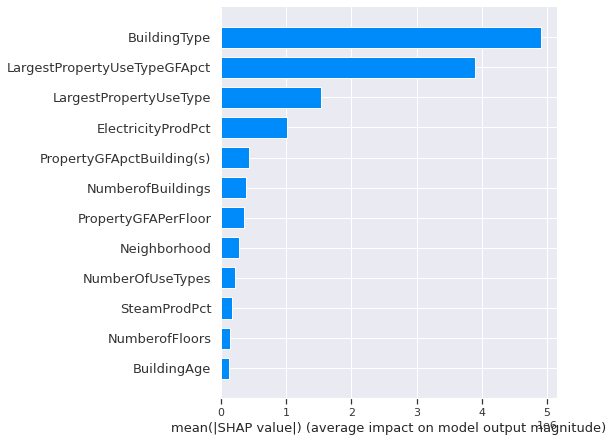

In [51]:
shap.summary_plot(shap_values, X_temp, feature_names = getColumnNames(model, choixEncoder, X_train, poly = False), plot_type="bar")

# <font color='red'> RESULTATS </font>

In [52]:
bestModelsDF.insert(loc = len(bestModelsDF.columns),value = TestRMSE, column = "TestRMSE")
bestModelsDF.insert(loc = len(bestModelsDF.columns),value = TestR2, column = "TestR2")
bestModelsDF

,params,mean_train_neg_root_mean_squared_error,mean_train_r2,mean_test_neg_root_mean_squared_error,mean_test_r2,mean_fit_time,TestRMSE,TestR2
Linear Regression,{'linearregression__fit_intercept': False},-10283446.136125,0.494723,-9323822.684867,0.483212,0.034027,7.779967e+06,0.439089
Ridge Regression,"{'ridge__alpha': 1.0, 'ridge__fit_intercept': ...",-10283450.361207,0.494723,-9322546.436059,0.483375,0.041351,7.778880e+06,0.439246
Lasso,"{'lasso__alpha': 1.0, 'lasso__fit_intercept': ...",-10283446.136125,0.494723,-9323822.019681,0.483212,0.043017,7.779966e+06,0.439090
Random Forest Regressor,{'randomforestregressor__n_estimators': 35},-3808933.31051,0.93004,-8702320.397745,0.549147,0.147248,7.513260e+06,0.476888
Random Forest Regressor & Polynomial Features,{'randomforestregressor__n_estimators': 100},-3628849.766417,0.936809,-9024951.376392,0.502914,16.629543,6.874662e+06,0.562034
Random Forest Regressor & Logarithmic transformer,{'transformedtargetregressor__regressor__n_est...,-5221000.730618,0.868533,-8691018.983204,0.548934,0.106098,6.718515e+06,0.581703
Gradient Boosting Regressor,{'gradientboostingregressor__n_estimators': 200},-2771384.321583,0.963216,-8786390.525415,0.536337,0.25732,6.939910e+06,0.553681
